# Reward shaping analysis

We import all things needed, starting by inserting the project path in order to have access to our custom-made `utils` package.

_Note_: You can modify the project path as you wish, depending on the location of your project folder. For me, it's under `~/Projects`.

In [1]:
import sys
from pathlib import Path

# Modify this as you wish, used for importing custom project packages, such as `utils`
project_path = str(Path.home()) + "\\Projects\\rlgym_demo"

sys.path.insert(0, project_path)

We can then import all the tools we are going to use

In [2]:
import numpy as np
from rlgym.utils import common_values
from utils.analysis.reward_functions import common, extra
from utils.analysis import plotting

We retrieve the arena positions of the arena `Triangulation` object, used for creating the plots

In [3]:
arena_positions = plotting.arena_positions

and begin with common rewards.

## Common rewards

The first type of common rewards in the list are ball to goal rewards.

### Ball2Goal

We set an arbitrary ball position.

In [4]:
ball_position = np.array([-1800, 1800, 400])

Ball to goal rewards are divided into three types:
- Distance to goal
- Distance from goal wall
- Ball to goal velocity

For each of them, we compute the reward function values across the field and proceed to plot them, along with the ball position and its reward, including the ball's linear velocity vector, whenever available.

#### Distance to goal

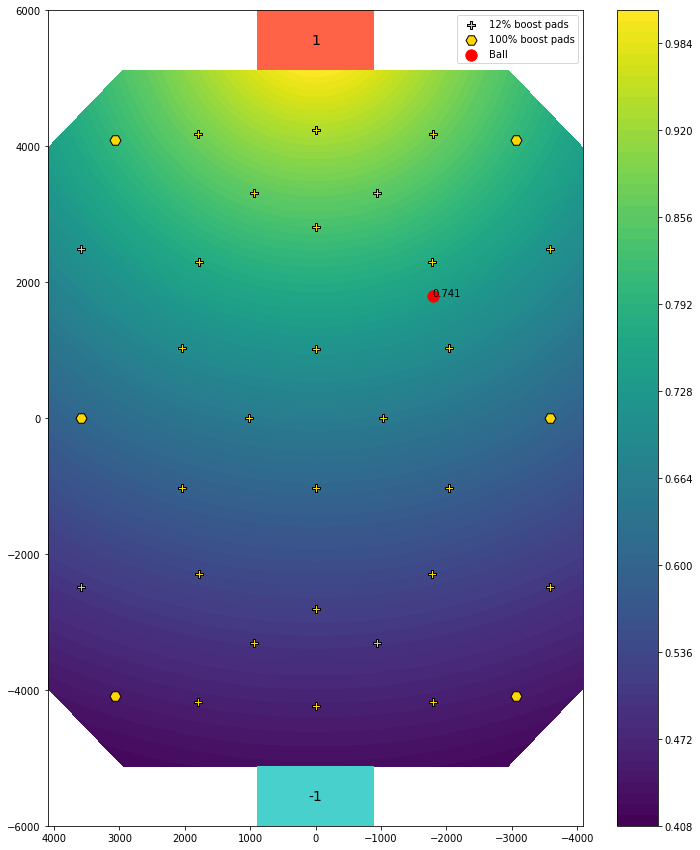

In [5]:
ball_zs = common.ball_goal.liu_dist_ball2goal(arena_positions)
plotting.arena_contour(ball_zs, ball_position=ball_position, annotate_ball=True)

####  Distance from goal wall

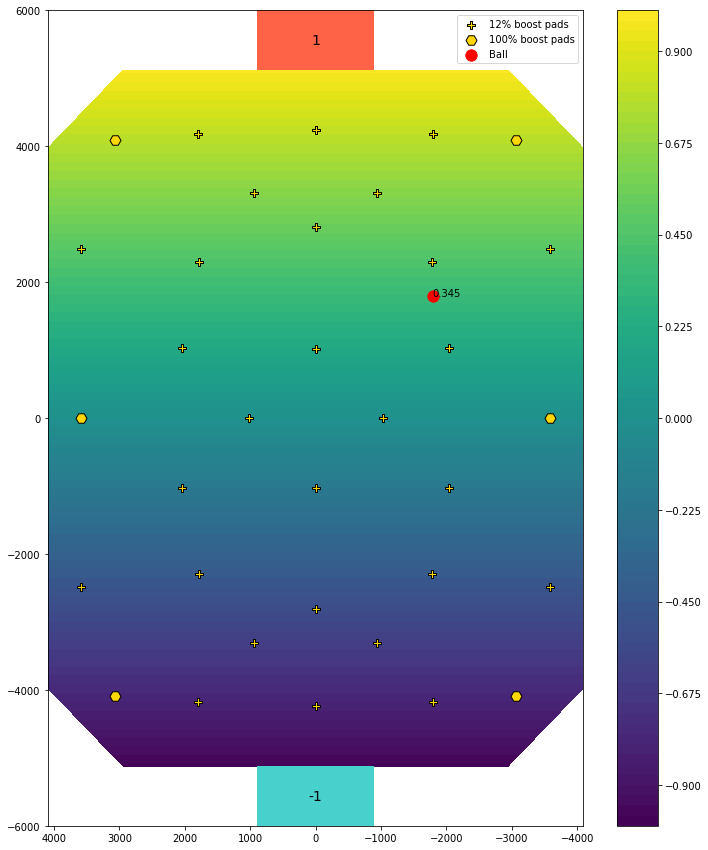

In [6]:
ball_zs = common.ball_goal.ball_y_coord(arena_positions)
plotting.arena_contour(ball_zs, ball_position=ball_position, annotate_ball=True)

#### Ball to goal velocity

You can play around with the values of ball linear velocity. First axis is the x axis (side to side), second is y (goal to goal), third is z (up/down).

**_Note_**: ball maximum linear velocity is 6000, any more is not reflective of the true reward.

In [7]:
ball_lin_velocity = np.array([0, 5999, -40], dtype=float)
ball_lin_velocity_vec_len = np.linalg.norm(ball_lin_velocity).item()
print("Ball linear velocity vector length is " + str(ball_lin_velocity_vec_len))
assert ball_lin_velocity_vec_len <= common_values.BALL_MAX_SPEED, "Max ball linear velocity vector length must be less than or equal to 6000"

Ball linear velocity vector length is 5999.13335407707


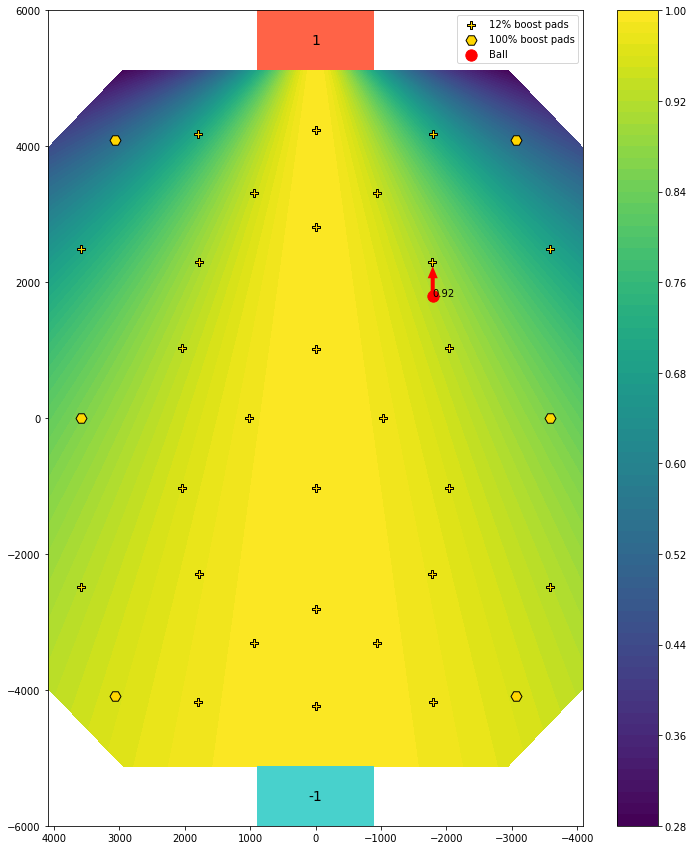

In [8]:
ball_zs = common.ball_goal.velocity_ball2goal(arena_positions, ball_lin_velocity)
plotting.arena_contour(ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       annotate_ball=True)

### Conditional

The second type of common rewards are conditional rewards. Those rewards happen only when a provided condition applies.

Conditional rewards are divided into three types:
- Closest to ball
- Touched last
- Behind ball

#### Closest2ball

We begin with the first conditional reward, `closest2ball` which receives a series of arguments as such:

`(player_positions, player_idx, team_idx, ball_position, team_only)`

where:
- player_positions: A numpy array  consisting of blue or blue and orange team positions of shape (`n_blue_team` + `n_orange_team`, 3)
- player_idx: The index of the player the rewards are computed for
- team_idx: A list of 0s and 1s signifying blue and orange team players
- ball_position: A numpy array indicating the position of the ball of shape (3,)
- team_only: A boolean indicating whether rewards are computed for the team of player with index `player_idx` or for both teams. Defaults to `True`.

We set some arbitrary positions for the blue team

In [9]:
player_positions = np.array([[100, 400, 200], [1200, -600, 300]])

Out of the two players, the player with index 0 is the one that is closest, which is also visible with a simple plot.

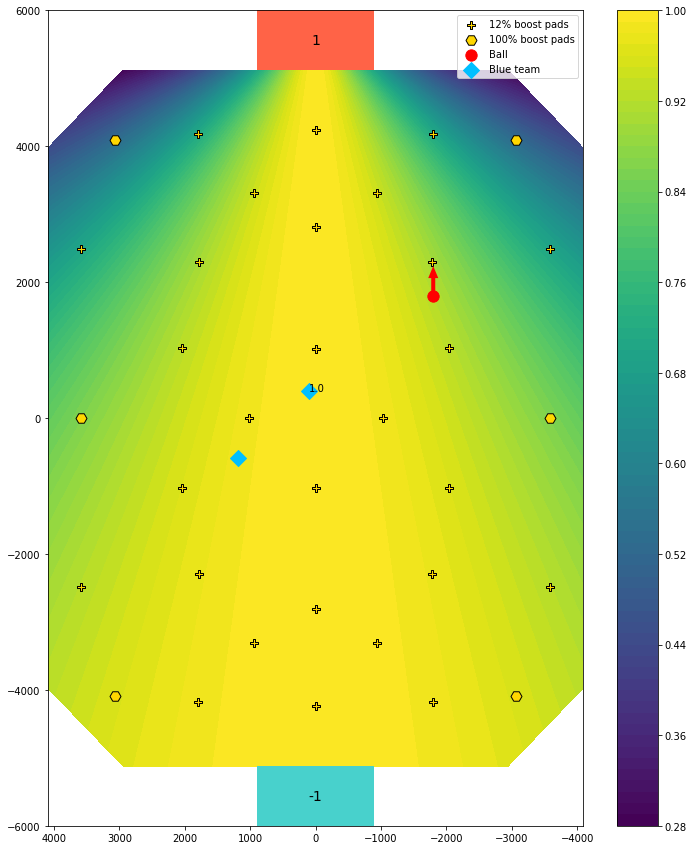

In [10]:
plotting.arena_contour(ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions)

And this is also verifiable through the conditional method

In [11]:
team_idx = [0, 0]
player_idx = 0
condition_args = (player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

True

In [12]:
team_idx = [0, 0]
player_idx = 1
condition_args = (player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

False

The same would also apply if all cars in the team were orange

In [13]:
team_idx = [1, 1]
player_idx = 0
condition_args = (player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

True

In [14]:
team_idx = [1, 1]
player_idx = 1
condition_args = (player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

False

In the conditions above, we consider distances among team cars only.

Therefore, if cars belong to different teams, the condition applies for both of them.

In [15]:
team_idx = [0, 1]
player_idx = 0
condition_args = (player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

True

In [16]:
team_idx = [0, 1]
player_idx = 1
condition_args = (player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

True

Now, let's consider two new teams.

In [17]:
blue_positions = np.array([[100, 400, 200], [1200, -600, 300]])
orange_positions = np.array([[-2000, 3500, 250], [2300, 3000, 50]])
player_positions = (blue_positions, orange_positions)

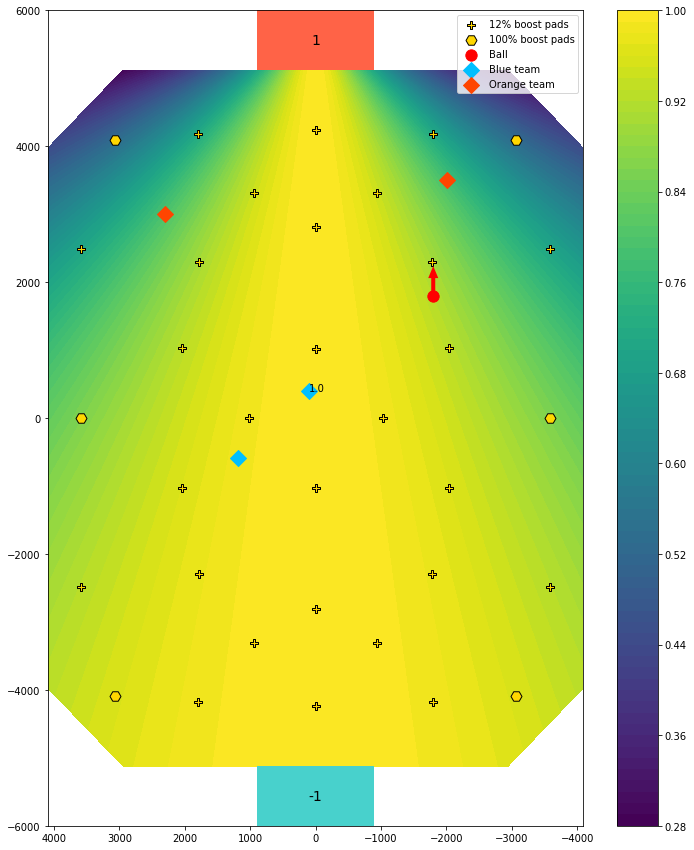

In [18]:
plotting.arena_contour(ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions)

Out of the two teams, the orange player with orange index 0 is closest to the ball.

In [19]:
team_idx = [0] * len(player_positions[0]) + [1] * len(player_positions[1])
team_only = False

In [20]:
# Blue team plus orange index
player_idx = len(player_positions[0]) + 0
# This time we concatenate because player_positions is a tuple
condition_args = (np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
common.conditional("closest2ball", condition_args)

True

In [21]:
player_idx = 0
condition_args = (np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
common.conditional("closest2ball", condition_args)

False

But supposing we consider teams only, blue player 0 is still found to be closest to the ball, along with orange player 0.

In [22]:
team_only = True

In [23]:
# Blue team plus orange index
player_idx = len(player_positions[0]) + 0
condition_args = (np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
common.conditional("closest2ball", condition_args)

True

In [24]:
player_idx = 0
condition_args = (np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
common.conditional("closest2ball", condition_args)

True

To return to our original argument, conditional rewards are given only when certain conditions apply, which we can examine using the `conditional` method.

So, in order to retrieve a specified reward, or a zero reward, all that remains is to multiply our reward array with the conditional boolean.

In [25]:
team_idx = [0] * len(player_positions[0]) + [1] * len(player_positions[1])
team_only = False
# Orange player 0
player_idx = len(player_positions[0]) + 0
condition_args = (np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
condition_applies = common.conditional("closest2ball", condition_args)
condition_applies

True

In [26]:
conditional_zs = ball_zs * condition_applies

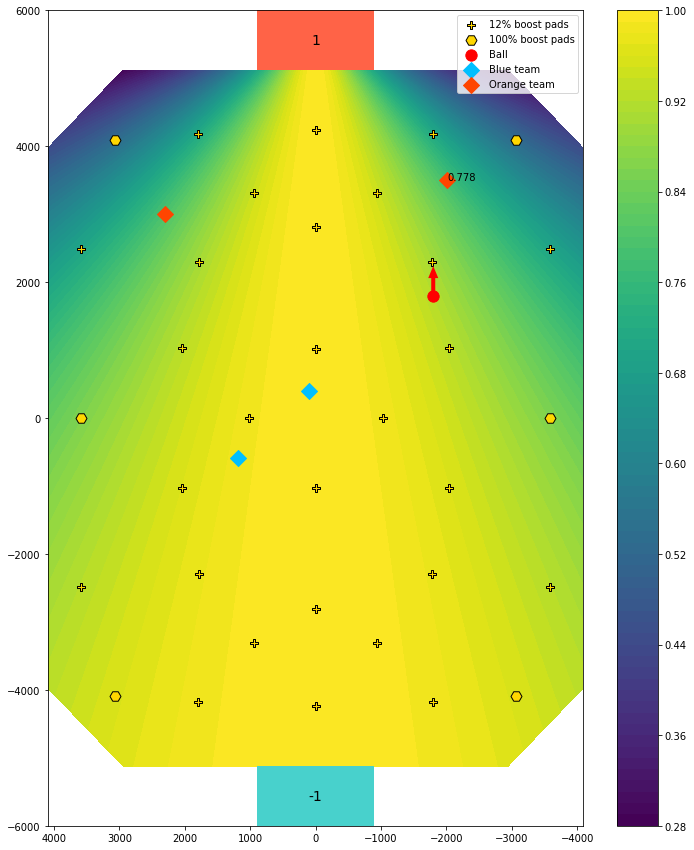

In [27]:
# This time we suppose the reward plot applies for orange player 0
plotting.arena_contour(conditional_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_idx=player_idx)  # Notice the plot as the player_idx changes

In [28]:
team_idx = [0] * len(player_positions[0]) + [1] * len(player_positions[1])
team_only = False
# Blue player 0
player_idx = 0
condition_args = (np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
condition_applies = common.conditional("closest2ball", condition_args)
condition_applies

False

In [29]:
conditional_zs = ball_zs * condition_applies

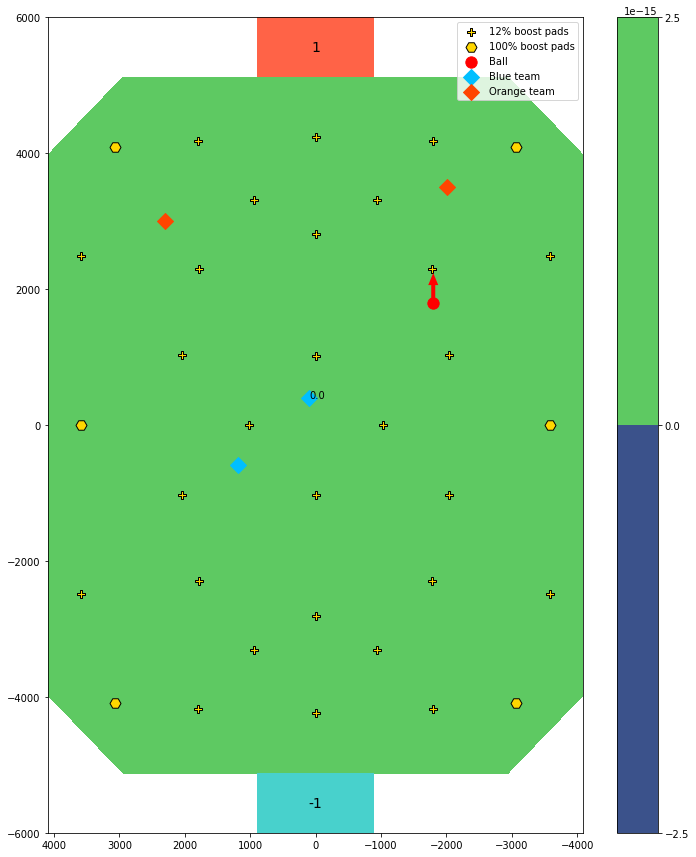

In [30]:
plotting.arena_contour(conditional_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_idx=player_idx)  # Notice the plot as the player_idx changes

#### Touched last

The second type of conditional rewards is the `touched_last` reward. This reward happens only when the player examined is the last one that has touched the ball.

In order to encode this into our plots, an easy way is to use a simple boolean. Therefore, the `touched_last` conditional arguments consist of one boolean only.

In [31]:
condition_applies = common.conditional("touched_last", False)
condition_applies

False

In [32]:
condition_applies = common.conditional("touched_last")  # condition_params defaults to True
condition_applies

True

#### Behind ball

The third and final conditional reward is the `behind_ball` condition, which happens only when the player is behind the ball on the field, which is determined by its y axis.

This means that based on the blue and orange player positions we have specified thus far, the blue team is behind the ball, while the orange team is in front of it.

The `behind_ball` condition receives three arguments:
- The player position,
- the ball position
- and an orange team flag.

The blue team is behind the ball

In [33]:
condition_args = (blue_positions[0], ball_position)
common.conditional("behind_ball", condition_args)

True

In [34]:
condition_args = (blue_positions[1], ball_position)
common.conditional("behind_ball", condition_args)

True

While the orange team is in front of it.

In [35]:
condition_args = (orange_positions[0], ball_position)
common.conditional("behind_ball", condition_args)

False

In [36]:
condition_args = (orange_positions[1], ball_position)
common.conditional("behind_ball", condition_args)

False

If we switch sides however...

In [37]:
condition_args = (blue_positions[0], ball_position, True)
common.conditional("behind_ball", condition_args)

False

In [38]:
condition_args = (blue_positions[1], ball_position, True)
common.conditional("behind_ball", condition_args)

False

In [39]:
condition_args = (orange_positions[0], ball_position, True)
common.conditional("behind_ball", condition_args)

True

In [40]:
condition_args = (orange_positions[1], ball_position, True)
common.conditional("behind_ball", condition_args)

True

### Misc

The third type of rewards are miscellaneous or `misc` rewards.

Misc rewards include the following:
- Event
- Velocity
- Save boost
- Constant
- Align ball

#### Event

Event rewards are rewards that naturally add up when events happen.

By default, the event reward receives 7 types of events:
- goal
- team_goal
- concede
- touch
- shot
- save
- demo

The event reward receives a tuple of arguments. If within the tuple we pass only the reward values, we retrieve a simple sum over them.

In [41]:
common.event(([10, 7, 0, 0, 3, 0, 0],))

20

Additionally, we can also specify which rewards hold true using a list of flags.

In [42]:
common.event(([0, 1, 1, 1, 0, 1, 0], [10, 7, 0, 0, 3, 0, 0]))

7

We can specify our own events.

In [43]:
common.event(([0, 2, 5],), ["goal", "demo", "concede"])

7

Or remove events from the default list.

In [44]:
common.event(([10, 7, 0, 0, 3, 0],), remove_events="demo")

20

In [45]:
common.event(([10, 7, 0, 0, 3],), remove_events=["demo", "save"])

20

In [46]:
common.event(([10, 7, 0, 0, 3],), remove_events=[-1, -2])  # event indices

20

In [47]:
common.event(([10, 7, 0, 0, 3],), remove_events=[-1, "save"])  # mixed arguments are also possible

20

Lastly, we can add our own custom events

In [48]:
common.event(([10, 7, 0, 0, 3, 0, 0, 5],), add_events="demoed")

25

In [49]:
common.event(([10, 7, 0, 0, 3, 0, 0, 5, -4],), add_events=["demoed", "timeout"])

21

In [50]:
common.event(([0, 2, 5],), ["goal", "demo", "concede"], remove_events=["demo"], add_events=["timeout"])

7

Supposing we want to plot those scalar rewards using our contour plot, we can do so as such:

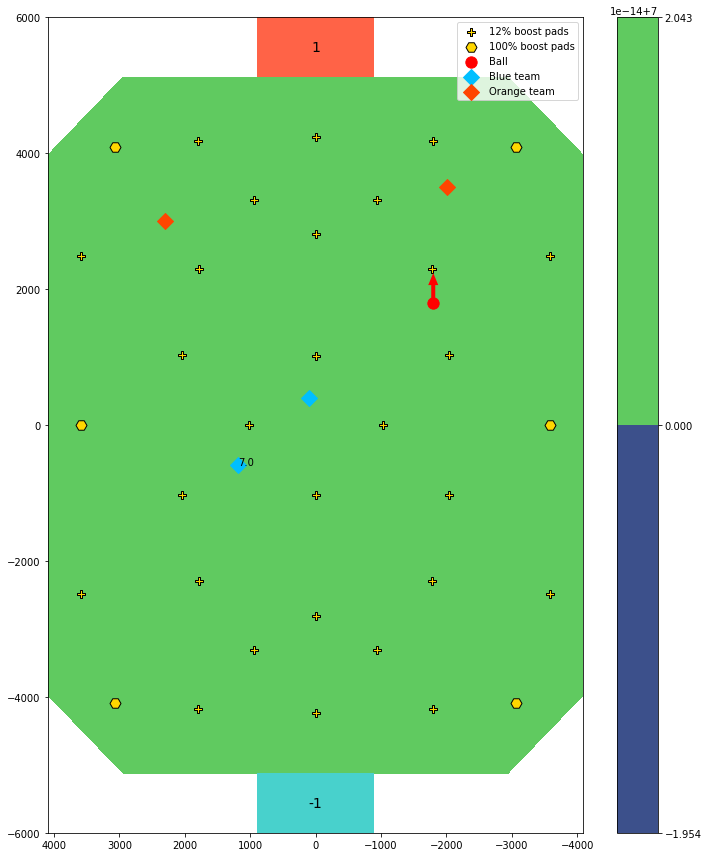

In [51]:
event_zs = common.event(([0, 2, 5],),
                        ["goal", "demo", "concede"],
                        remove_events=["demo"],
                        add_events=["timeout"])
event_zs = np.ones(arena_positions.shape[0]) * event_zs
plotting.arena_contour(event_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_idx=1)

#### Velocity

Another misc reward is velocity. Velocity is commonly used as a dummy reward to verify that things work out as expected.

Velocity is normalized by the player maximum velocity which is 2300 units/sec.

In [52]:
blue_lin_vels = np.array([[-1200, 600, 0], [-1200, 900, 0]])
orange_lin_vels = np.array([[200, -700, 150], [-1000, -1100, 400]])
player_lin_vels = (blue_lin_vels, orange_lin_vels)

In [53]:
np.linalg.norm(blue_lin_vels[0])

1341.640786499874

In [54]:
common_values.CAR_MAX_SPEED

2300

In [55]:
np.linalg.norm(blue_lin_vels[0]) / common_values.CAR_MAX_SPEED

0.5833220810869018

In [56]:
common.velocity(blue_lin_vels[0])

0.5833220810869018

In [57]:
event_vel_zs = event_zs + common.velocity(blue_lin_vels[0])

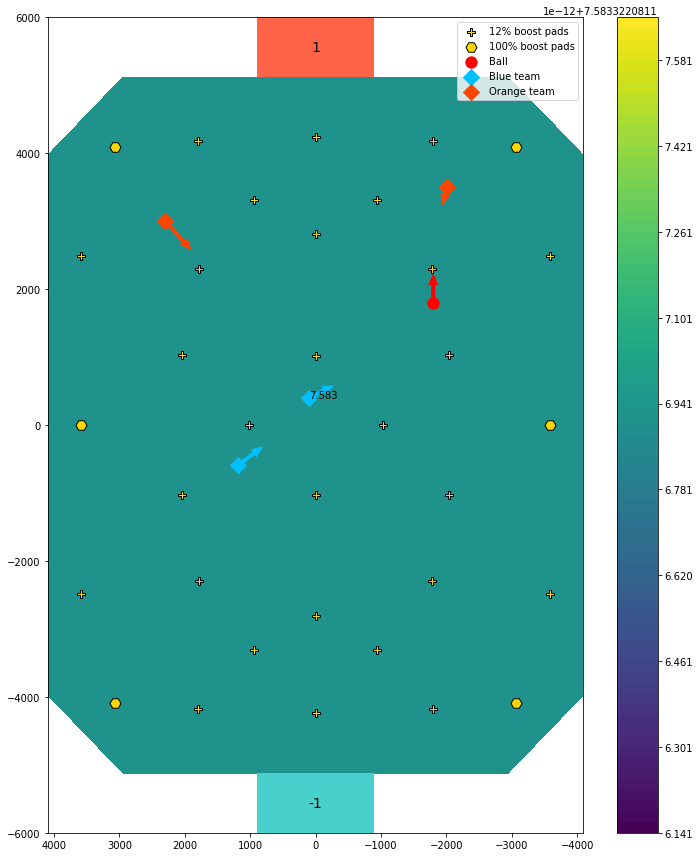

In [58]:
plotting.arena_contour(event_vel_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_lin_vels=player_lin_vels
                       )

The velocity reward can also receive a multitude of different velocities.

The following velocities should produce a reward that peaks on the two ends of the distribution and dips at the center.

In [59]:
dummy_vel_x = np.linspace(1600, -1600, 300)
dummy_vel_y = np.linspace(1600, -1600, 300)
dummy_vel_z = np.ones_like(dummy_vel_x) * 50

dummy_vels = np.stack((dummy_vel_x, dummy_vel_y, dummy_vel_z), -1)

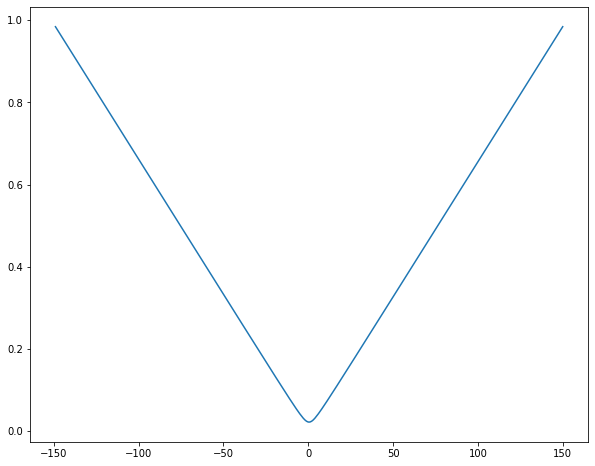

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(np.linspace(-149, 150, 300), common.velocity(dummy_vels))
plt.show()

#### Save boost

Save boost is a simple reward that computes the square root of available boost the player has.

Boost amount varies between 0 and 100.

In [61]:
boost_amount = 37

In [62]:
common.save_boost(boost_amount)

6.082762530298219

In [63]:
event_vel_boost_zs = event_vel_zs + common.save_boost(boost_amount)

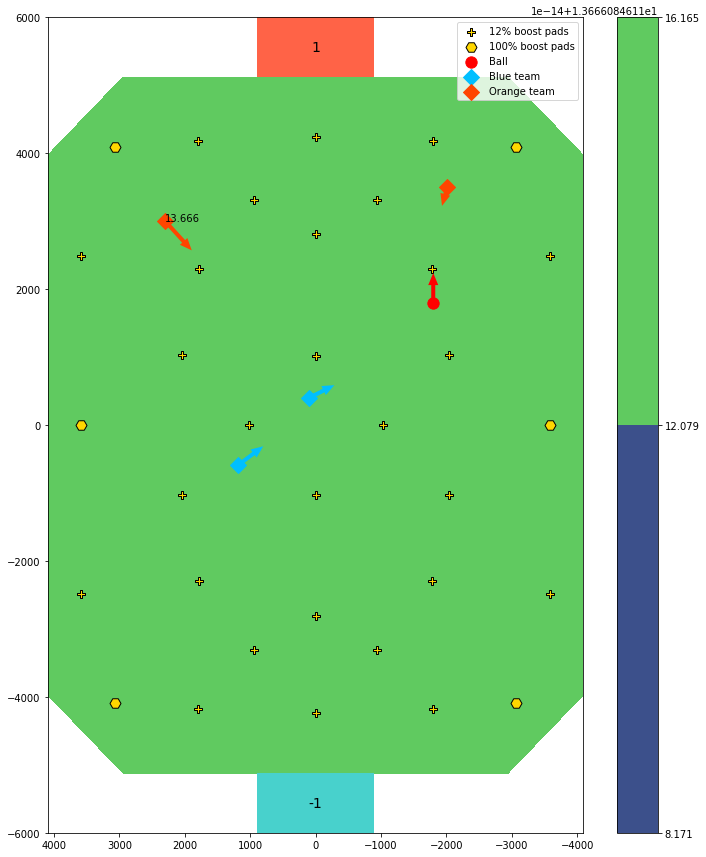

In [64]:
plotting.arena_contour(event_vel_boost_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_lin_vels=player_lin_vels,
                       player_idx=3
                       )

#### Constant

Constant reward is a simple scalar reward

In [65]:
common.constant(-0.5)

-0.5

In [66]:
event_vel_boost_const_zs = event_vel_boost_zs + common.constant(-0.5)
event_vel_boost_const_zs.shape

(197633,)

In [67]:
event_vel_boost_const_zs.shape[0] == arena_positions.shape[0]

True

#### Align ball

The final misc reward is the `align_ball` reward. The reward computes the cosine similarity between the player to ball and player to goal vectors, both for offense and defense.

For example, for offense, if the player is situated behind the orange goal as well as the ball, then the cosine similarity between the two vectors approaches 1. Otherwise, the cosine similarity approaches -1.

For defense, a similar reward is computed for the blue goal.

Both rewards for offense and defense are computed and subsequently added up.

Based on all of the above, this means that if the player is at the center of the y axis, and the ball is also at the center of the y axis, next to the player, both offensive and defensive rewards tend to 0, since the two vectors get close to orthogonal. And this makes sense, since such a position is neither good for scoring a goal nor for defending the player's own goal.

In [68]:
common.align_ball(blue_positions[0], ball_position)

array([1.18376684])

In [69]:
common.align_ball(blue_positions[1], ball_position)

array([1.19430043])

For computing orange team rewards, we need to invert the y axis

In [70]:
common.align_ball(orange_positions[0], ball_position, orange=True)

array([1.69045913])

In [71]:
common.align_ball(orange_positions[1], ball_position, orange=True)

array([0.14551781])

Case for y axis = 0

In [72]:
# we specify similar z axes in order to retrieve a reward of 0
p_align_player_pos = np.array([-200, 0, 300])
p_align_ball_pos = np.array([200, 0, 300])

In [73]:
common.align_ball(p_align_player_pos, p_align_ball_pos)

array([0.])

Lastly, we can plot all align boal rewards, depending on the ball position, on the arena plot.

In [74]:
align_ball_blue_zs = common.align_ball(arena_positions, ball_position)

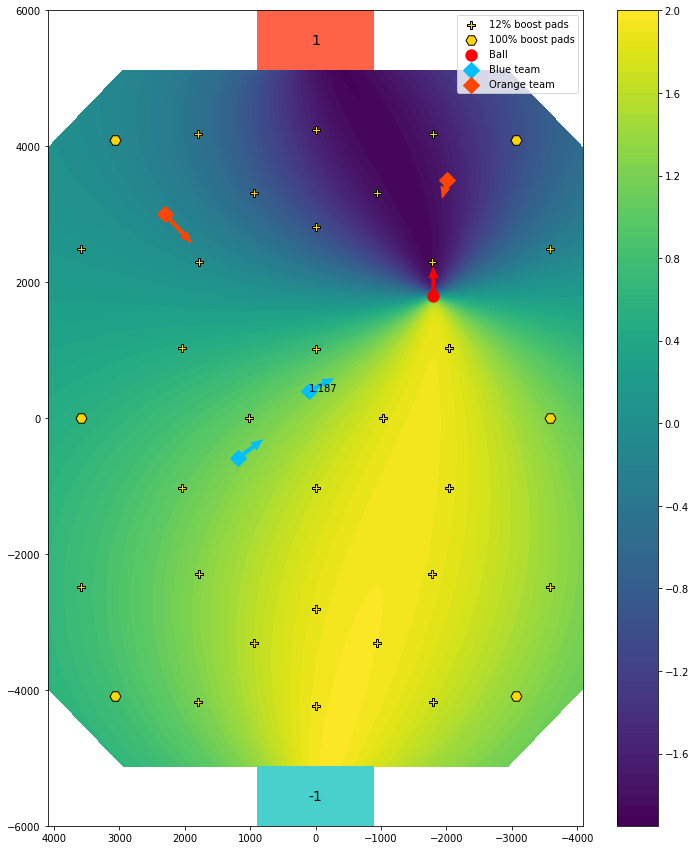

In [75]:
plotting.arena_contour(align_ball_blue_zs,
                       ball_position,
                       ball_lin_velocity,
                       player_positions,
                       player_lin_vels
                       )

And if we invert the y axis, we see a complementary result for the orange team

In [76]:
align_ball_orange_zs = common.align_ball(arena_positions, ball_position, orange=True)

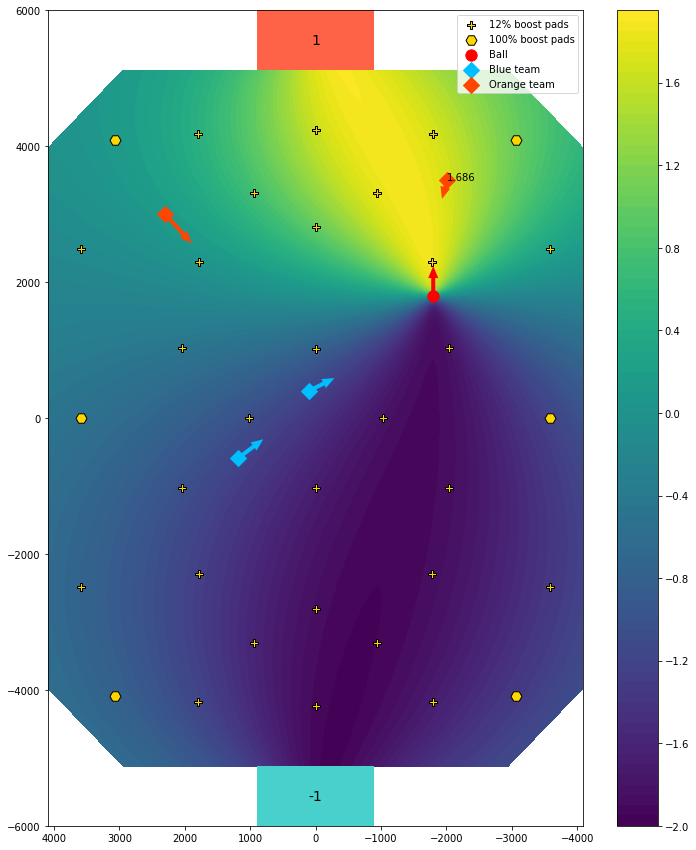

In [77]:
plotting.arena_contour(align_ball_orange_zs,
                       ball_position,
                       ball_lin_velocity,
                       player_positions,
                       player_lin_vels,
                       player_idx=2
                       )

And if we add them up...

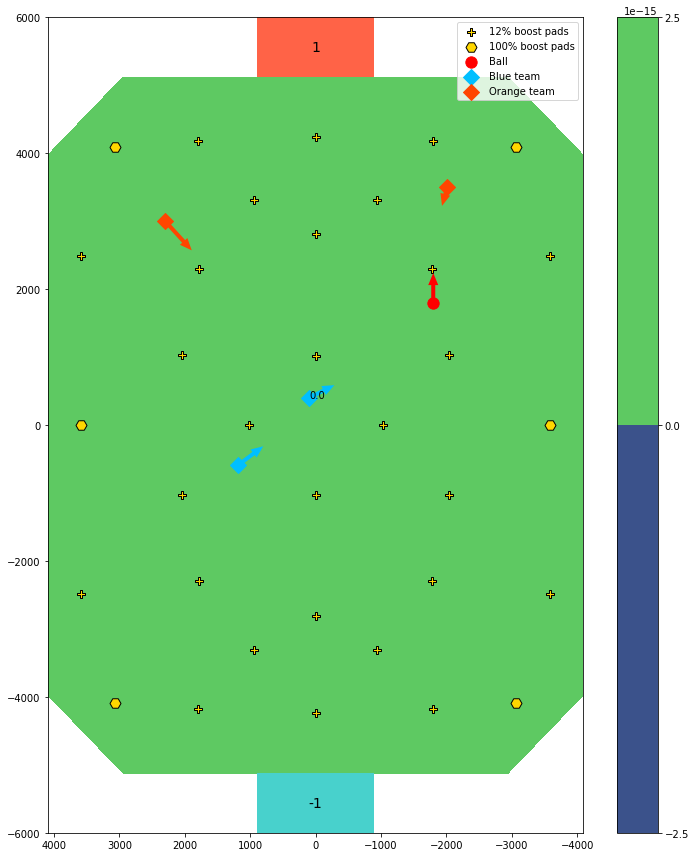

In [78]:
plotting.arena_contour(align_ball_blue_zs + align_ball_orange_zs,
                       ball_position,
                       ball_lin_velocity,
                       player_positions,
                       player_lin_vels
                       )

which makes perfect sense.

### Player2ball

The last type of common rewards are player to ball rewards. Player to ball rewards include the following:
- Distance to ball
- Velocity to ball
- Face ball
- Touch ball

#### Distance to ball

In [79]:
dist2ball_zs = common.liu_dist_player2ball(arena_positions, ball_position)

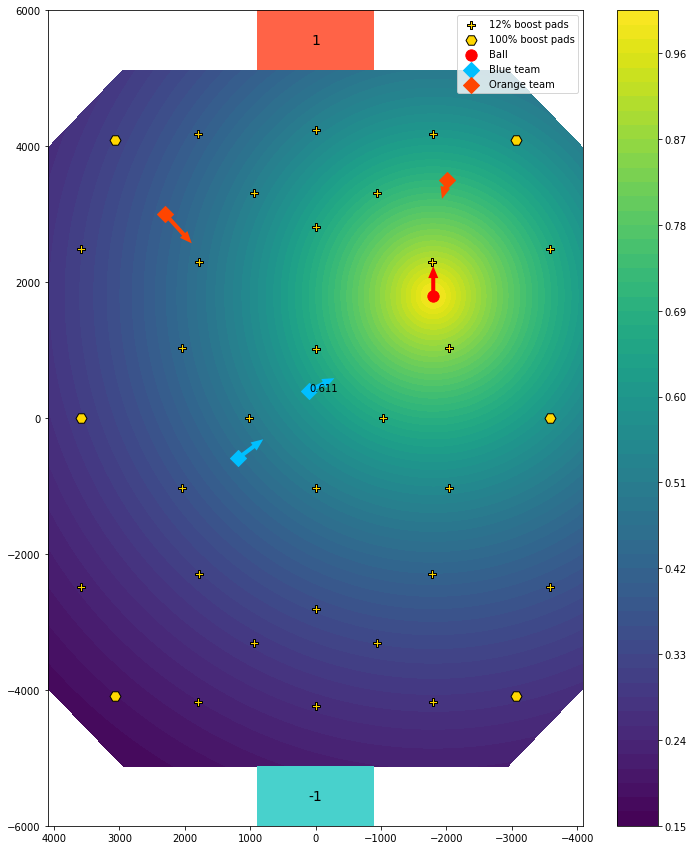

In [80]:
plotting.arena_contour(dist2ball_zs,
                       ball_position,
                       ball_lin_velocity,
                       player_positions,
                       player_lin_vels
                       )

#### Velocity to ball

In [81]:
vel2ball_zs = common.velocity_player2ball(arena_positions,
                                          blue_lin_vels[0],
                                          ball_position)

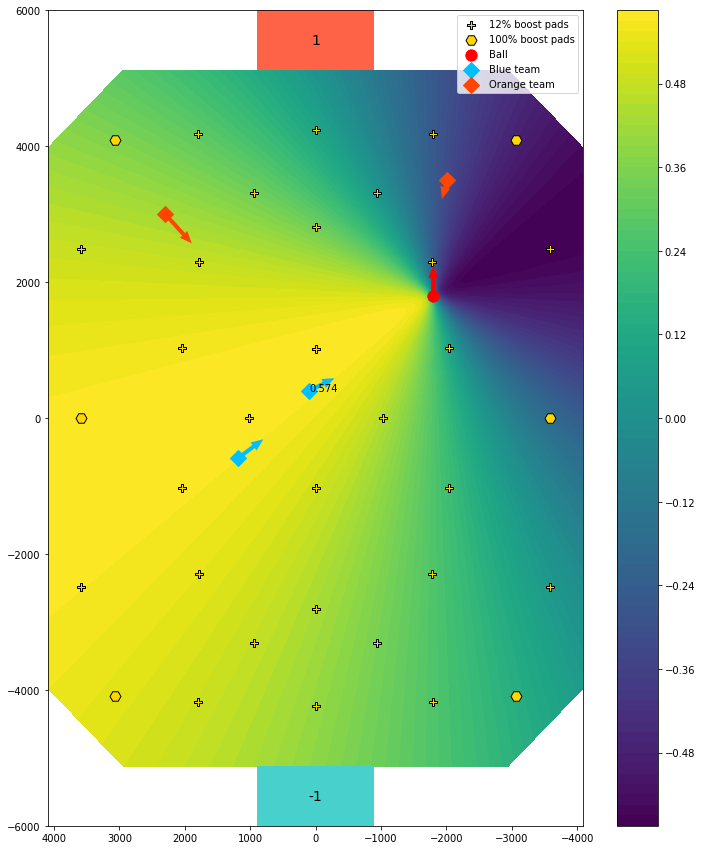

In [82]:
plotting.arena_contour(vel2ball_zs,
                       ball_position,
                       ball_lin_velocity,
                       player_positions,
                       player_lin_vels
                       )

In [83]:
vel2ball_zs = common.velocity_player2ball(arena_positions,
                                          blue_lin_vels[1],
                                          ball_position)

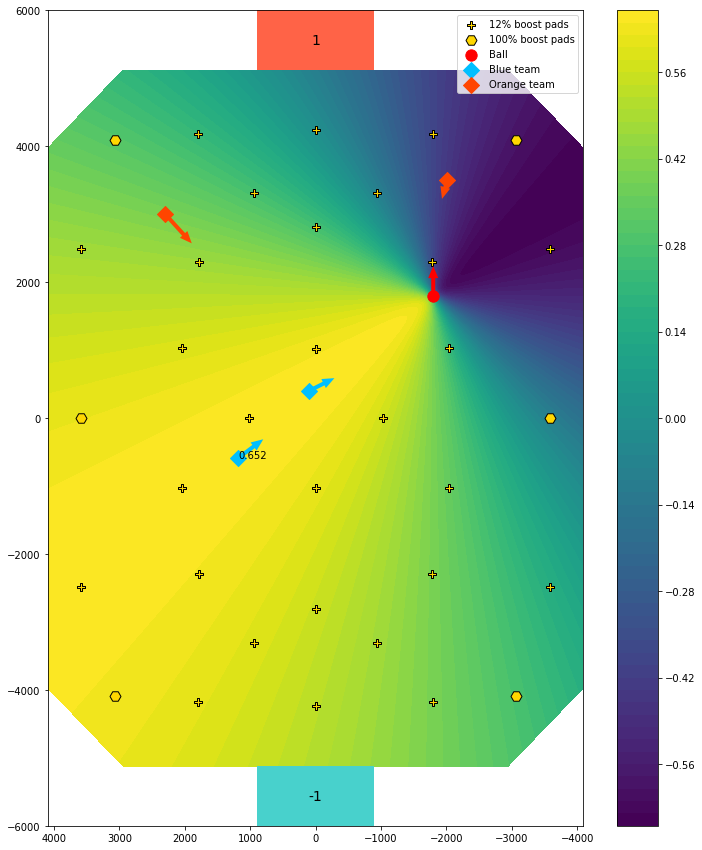

In [84]:
plotting.arena_contour(vel2ball_zs,
                       ball_position,
                       ball_lin_velocity,
                       player_positions,
                       player_lin_vels,
                       player_idx=1
                       )

#### Face ball

The face ball reward rewards the player if the player's car x axis (nose) is directed toward the goal.

We present four cases.
- The player's nose is directed toward the positives of the y axis
- The player is looking to the side of the arena, toward the positives of the x axis
- The player is looking somewhat toward the ball, which is reflective of a typical Rocket League game scenario
- The player is looking at the opposite side of the ball

 At each case, the ball is placed in front of the player, on the same y position.

In [85]:
blue_face_position = np.array([[-1800, -1800, 150]])

When the player is facing toward the ball the reward is 1

In [86]:
blue0_forward_rot = np.array([[0, 1, 0]])

In [87]:
faceball_zs = common.face_ball(arena_positions, ball_position, blue0_forward_rot)

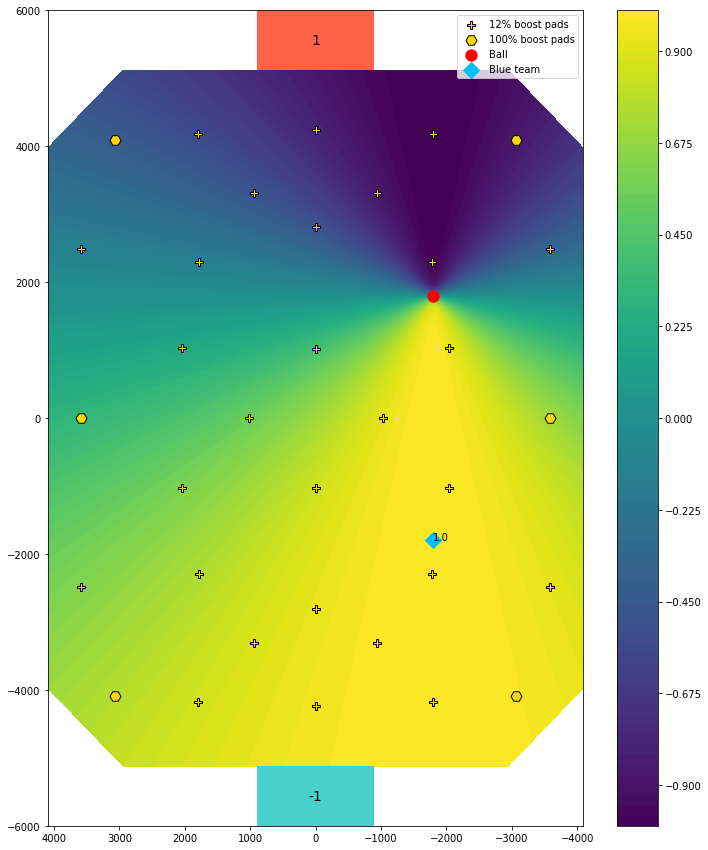

In [88]:
plotting.arena_contour(faceball_zs,
                       ball_position,
                       player_positions=blue_face_position,
                       )

When the player is facing to the side, they receive a reward of 0

In [89]:
blue0_forward_rot = np.array([[1, 0, 0]])

In [90]:
faceball_zs = common.face_ball(arena_positions, ball_position, blue0_forward_rot)

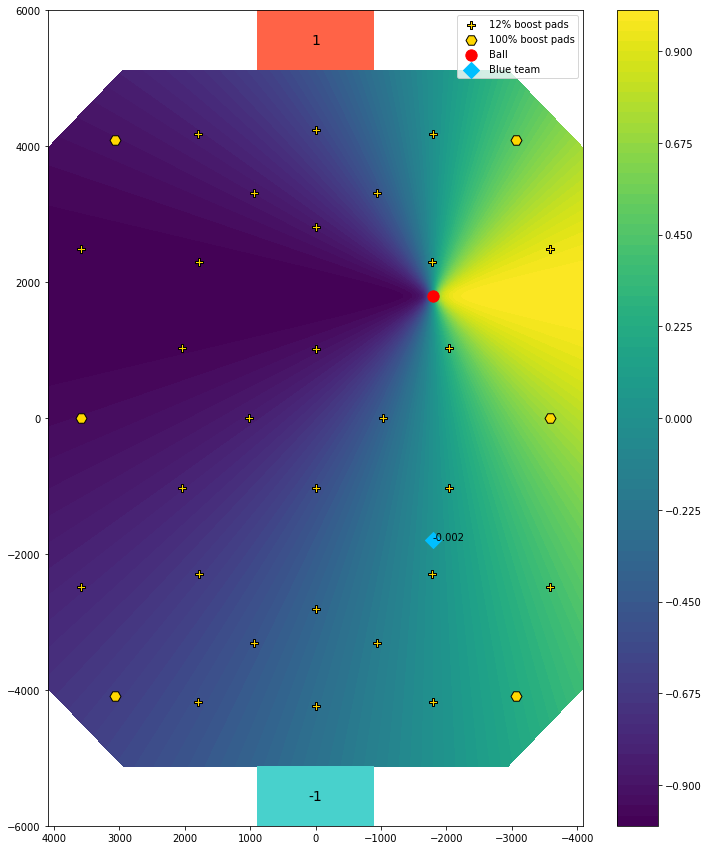

In [91]:
plotting.arena_contour(faceball_zs,
                       ball_position,
                       player_positions=blue_face_position,
                       )

When the player is facing somewhere toward the ball, the reward is a positive number toward 1

In [92]:
blue0_forward_rot = np.array([[-0.2, 0.8, 0.1]])

In [93]:
faceball_zs = common.face_ball(arena_positions, ball_position, blue0_forward_rot)

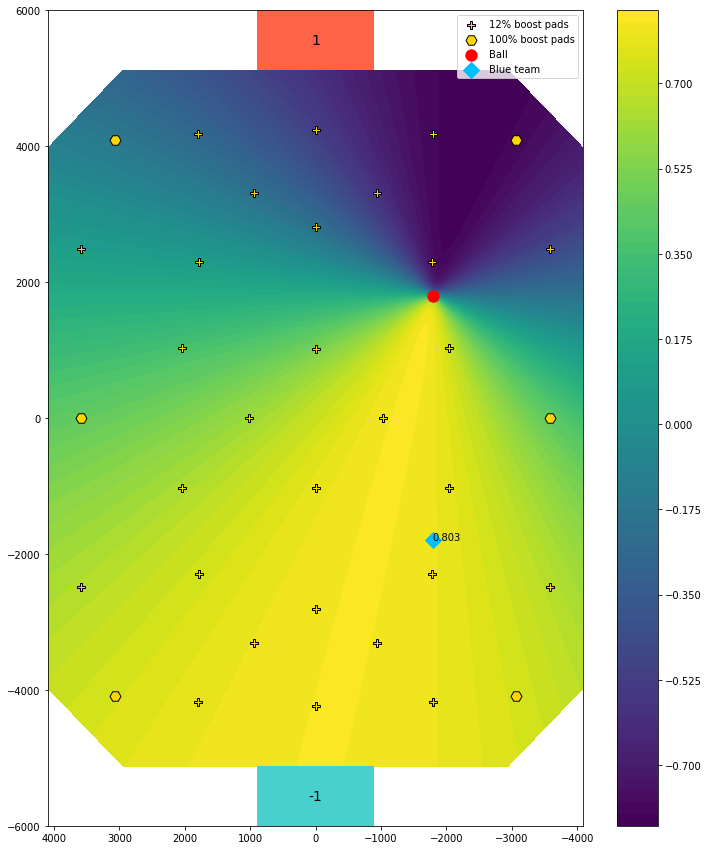

In [94]:
plotting.arena_contour(faceball_zs,
                       ball_position,
                       player_positions=blue_face_position,
                       )

And when the player is looking to the opposite side from the ball, they receive a reward of -1

In [95]:
blue0_forward_rot = np.array([[0, -1, 0]])

In [96]:
faceball_zs = common.face_ball(arena_positions, ball_position, blue0_forward_rot)

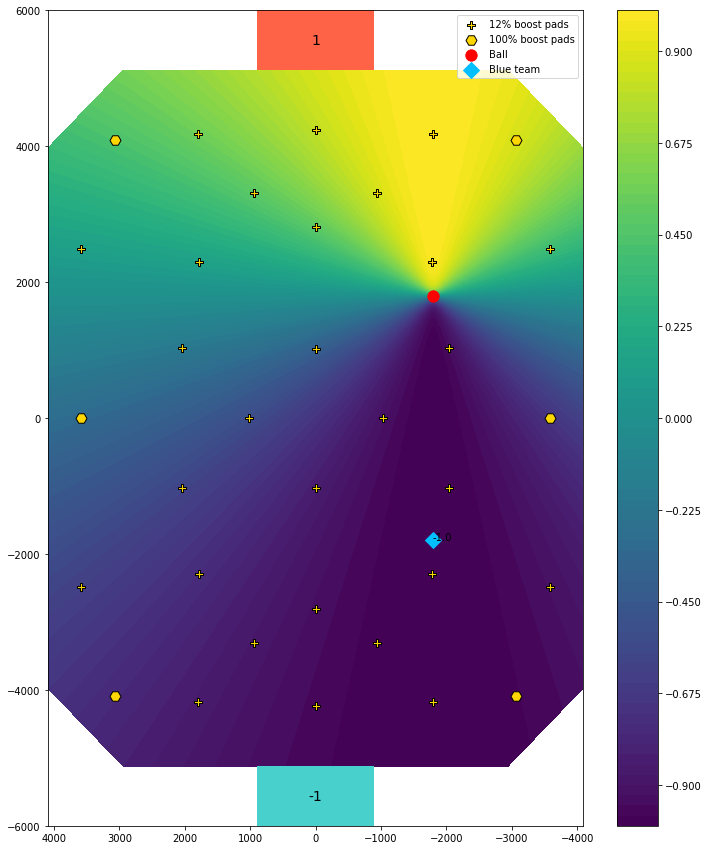

In [97]:
plotting.arena_contour(faceball_zs,
                       ball_position,
                       player_positions=blue_face_position,
                       )

#### Touch ball

The last type of player to ball rewards is the touch ball reward. The touch ball reward receives an aerial weight, and if the player touches the ball at a given height, they receive an exponential reward, proportional to the aerial weight.

If the weight is 0 (default) the player receives a reward of 1.

In [98]:
ball_position

array([-1800,  1800,   400])

In [99]:
common.touch_ball(ball_position)

1.0

In [100]:
common.touch_ball(ball_position, 1)

2.6563342318059298

In [101]:
common.touch_ball(ball_position, 2)

7.056111551063999

In [102]:
ball_position_aerial = np.array([-1800, 1800, 1500])

In [103]:
common.touch_ball(ball_position_aerial)

1.0

In [104]:
common.touch_ball(ball_position_aerial, 1)

8.586253369272237

In [105]:
common.touch_ball(ball_position_aerial, 2)

73.72374692133884

## Extra rewards

## Custom rewards

Problems with rewards:
- Liu distance gives positive rewards everywhere
- Boost save amount ranges from 0 to 10
- Align ball ranges between -2 and 2, a solution is setting defense and offense weight to 0.5